# N-R Team
## E Navaneet Kumar, Rithvika Paladugu

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
spark-3.5.1-bin-hadoop3/sbin/slaves.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-shuffle-service.sh
spark-3.5.1-bin-hadoop3/sbin/stop-history-server.sh
spark-3.5.1-bin-hadoop3/sbin/stop-worker.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-thriftserver.sh
spark-3.5.1-bin-hadoop3/sbin/start-worker.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-connect-server.sh


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells
import matplotlib.pyplot as plt # plotting graphs

In [6]:
spark = SparkSession.builder.appName('HW 9').getOrCreate()

In [7]:
spark

In [8]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']

In [10]:
ground_truth_df = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)

In [11]:
ground_truth_df

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1


In [12]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score']

In [17]:
scores_df = pd.read_csv('output1.txt', sep='|', names=scores_columns)

In [18]:
scores_df

,userID,trackID,album_score,artist_score
0,199810,208019,0.0,0.0
1,199810,74139,0.0,0.0
2,199810,9903,0.0,0.0
3,199810,242681,0.0,0.0
4,199810,18515,0.0,70.0
...,...,...,...,...
119995,249010,72192,0.0,0.0
119996,249010,86104,0.0,0.0
119997,249010,186634,90.0,90.0
119998,249010,293818,0.0,0.0


In [19]:
ratings_df = ground_truth_df.merge(scores_df, on=['userID', 'trackID']).fillna(0)    # inner join by default

In [20]:
ratings_df

,userID,trackID,ground_truth,album_score,artist_score
0,200031,30877,1,90.0,50.0
1,200031,8244,1,90.0,0.0
2,200031,130183,0,0.0,0.0
3,200031,198762,0,0.0,0.0
4,200031,34503,1,90.0,50.0
...,...,...,...,...,...
5995,212234,137371,0,0.0,0.0
5996,212234,42375,0,0.0,0.0
5997,212234,277867,1,90.0,90.0
5998,212234,83093,1,90.0,90.0


In [21]:
ratings_df.to_csv('ratings.csv', index=None)    # index=None means index column is not written to csv

In [22]:
ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)    # inferSchema scans csv twice to get datatype of each column

In [23]:
ratings_df

DataFrame[userID: int, trackID: int, ground_truth: int, album_score: double, artist_score: double]

In [24]:
ratings_df.count()

6000

In [25]:
ratings_columns = ratings_df.columns

In [26]:
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score
ground_truth,,,,
0,3000,3000,3000,3000
1,3000,3000,3000,3000


In [27]:
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [28]:
ratings_df = ratings_df.withColumn('ground_truth', ratings_df['ground_truth'].cast('string'))

In [29]:
ratings_df.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'double'),
 ('artist_score', 'double')]

In [30]:
feature_columns = ['album_score', 'artist_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [31]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [32]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

In [33]:
selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [34]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0]","[90.0, 0.0]","(0.0, 0.0)","(0.0, 0.0)","[90.0, 50.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90.0,90.0,0.0,0.0,90.0
artist_score,50.0,0.0,0.0,0.0,50.0


In [35]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2018)

In [36]:
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4260
Test Dataset Count: 1740


In [37]:
prediction_df = spark.read.csv('output1.txt', sep='|', inferSchema=True)    # inferSchema scans csv twice to get datatype of each column

In [38]:
prediction_df.count()

120000

In [39]:
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore")

In [40]:
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore']

In [41]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))

In [42]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0
prediction,0,0,0,0,0


In [43]:
prediction_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [44]:
feature_columns = ['albumScore', 'artistScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [45]:
label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [46]:
prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

In [47]:
selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)



In [48]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","[0.0, 70.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0


# Model 1 - Logistic Regression

In [49]:
from pyspark.ml.classification import LogisticRegression

In [50]:
start_time = time.time()

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
lr_model = lr.fit(train_df)                                                         # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 6.32 seconds.


In [51]:
lr_model.coefficients

DenseVector([0.0452, 0.0326])

In [52]:
beta = np.sort(lr_model.coefficients)    # return a sorted copy of an array

In [53]:
beta

array([0.03256793, 0.04519982])

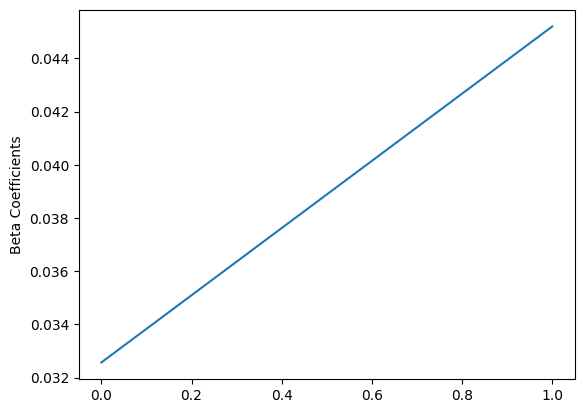

In [54]:
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [55]:
training_summary = lr_model.summary    # get summary (e.g. accuracy/precision/recall, objective history, total iterations) of model trained on the training set

In [56]:
roc = training_summary.roc.toPandas()    # get roc DF

In [57]:
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.039683
2,0.000000,0.040149
3,0.000000,0.040616
4,0.000000,0.041083
...,...,...
88,0.076015,0.783847
89,0.076487,0.783847
90,0.076959,0.783847
91,1.000000,1.000000


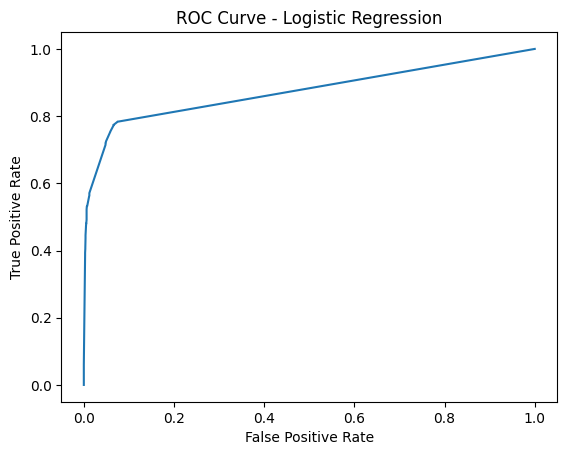

Training Set AUC = 0.8737133978552075


In [58]:
plt.plot(roc.FPR, roc.TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

In [59]:
predictions = lr_model.transform(test_df)    # transform test_df with logistic regression model
predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 124239|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 271459|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200085| 134106|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200099|  41892|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200106| 152491|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200124| 284066|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 131171|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 187136|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200160| 231

In [60]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200031|   8244|  1.0|[0.06488875729218...|[-2.6679911209111...|       1.0|
|200031|  30877|  1.0|[0.01343471003408...|[-4.2963878477543...|       1.0|
|200055|  56695|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 119451|  1.0|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [61]:
logistic_predictions = lr_model.transform(prediction_df)    # transform prediction_df with logistic regression model
logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
|199812| 276940|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 142408|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812| 130023|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812|  29189|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 223706|[0.13507641145138...|[-1.8568005370262...|       1.0|
|199812| 211361|[0.8

In [62]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [63]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)    # create a pandas df

In [64]:
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
1,199810,74139,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
2,199810,9903,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
3,199810,242681,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
4,199810,18515,"[0.2932269969682032, 0.7067730030317968]","[-0.8797625009202483, 0.8797625009202483]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119996,249010,293818,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119997,249010,110470,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0
119998,249010,186634,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0


In [65]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('lr_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [66]:
f_lr_predictions = open('lr_predictions.csv')
f_lr_final_predictions = open('lr_final_predictions.csv', 'w')

In [67]:
# Write header
f_lr_final_predictions.write('TrackID,Predictor\n')

18

In [68]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [69]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_lr_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_lr_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.26 seconds.


In [70]:
f_lr_predictions.close()
f_lr_final_predictions.close()

# Model 2 - Gradient-Boosted Tree Classifier

In [71]:
from pyspark.ml.classification import GBTClassifier

In [72]:
start_time = time.time()

gbt = GBTClassifier(maxIter=100)
gbt_model = gbt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 36.39 seconds.


In [73]:
predictions_gbt = gbt_model.transform(test_df)

In [74]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_gbt)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [75]:
sort_predictions_gbt = predictions_gbt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_gbt.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200031|  30877|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200031|   8244|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200055|  56695|  1.0|[0.01632026531261...|[-2.0494463824457...|       1.0|
|200065| 179571|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200065| 119451|  1.0|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [76]:
gbt_predictions = gbt_model.transform(prediction_df)    # transform prediction_df with gradient-boosted tree model
gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
|199812| 276940|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 142408|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812| 130023|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812|  29189|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 223706|[0.12602709898363...|[-0.9682762071735...|       1.0|
|199812| 211361|[0.8

In [77]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_gbt_predictions = gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gbt_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [78]:
pd_sort_gbt_predictions = sort_gbt_predictions.toPandas().fillna(0.0)    # create pandas df

In [79]:
pd_sort_gbt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
1,199810,74139,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
2,199810,9903,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
3,199810,242681,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
4,199810,18515,"[0.24633418901301743, 0.7536658109869826]","[-0.5591299711568518, 0.5591299711568518]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
119996,249010,293818,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
119997,249010,110470,"[0.0163202653126165, 0.9836797346873835]","[-2.0494463824457227, 2.0494463824457227]",1.0
119998,249010,186634,"[0.0163202653126165, 0.9836797346873835]","[-2.0494463824457227, 2.0494463824457227]",1.0


In [80]:
columns_to_write = ['userID', 'trackID']
pd_sort_gbt_predictions.to_csv('gbt_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [81]:
f_gbt_predictions = open('gbt_predictions.csv')
f_gbt_final_predictions = open('gbt_final_predictions.csv', 'w')

In [82]:
# Write header
f_gbt_final_predictions.write('TrackID,Predictor\n')

18

In [83]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [84]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_gbt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_gbt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.25 seconds.


In [85]:
f_gbt_predictions.close()
f_gbt_final_predictions.close()

# Model 3 - Decision Tree Classifier

In [92]:
from pyspark.ml.classification import DecisionTreeClassifier

In [93]:
start_time = time.time()

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
dt_model = dt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.87 seconds.


In [94]:
predictions_dt = dt_model.transform(test_df)

In [95]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_dt)    # evaluate decision tree model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [96]:
sort_predictions_dt = predictions_dt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_dt.show(6)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 130183|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200031|  30877|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200031|   8244|  1.0|[0.01470588235294...|    [1.0,67.0]|       1.0|
|200055|  56695|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200065| 179571|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200065| 119451|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 6 rows



In [97]:
dt_predictions = dt_model.transform(prediction_df)    # transform prediction_df with decision tree model
dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [98]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_dt_predictions = dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_dt_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [99]:
pd_sort_dt_predictions = sort_dt_predictions.toPandas().fillna(0.0)    # create pandas df

In [100]:
pd_sort_dt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [101]:
columns_to_write = ['userID', 'trackID']
pd_sort_dt_predictions.to_csv('dt_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without header)

In [102]:
f_dt_predictions = open('dt_predictions.csv')
f_dt_final_predictions = open('dt_final_predictions.csv', 'w')

In [103]:
# Write header
f_dt_final_predictions.write('TrackID,Predictor\n')

18

In [104]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [105]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_dt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_dt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.26 seconds.


In [106]:
f_dt_predictions.close()
f_dt_final_predictions.close()

Model 4 - Random Forest Classifier

In [139]:
from pyspark.ml.classification import RandomForestClassifier

In [140]:
start_time = time.time()

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 1.16 seconds.


In [126]:
predictions_rf = rf_model.transform(test_df)

In [127]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_rf)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [128]:
sort_predictions_rf = predictions_rf.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_rf.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80899124780892...|[16.1798249561785...|       0.0|
|200031|  30877|  1.0|[0.03077876214793...|[0.61557524295875...|       1.0|
|200031|   8244|  1.0|[0.00505128636157...|[0.10102572723155...|       1.0|
|200055|  56695|  1.0|[0.02245405248144...|[0.44908104962892...|       1.0|
|200065| 179571|  0.0|[0.80899124780892...|[16.1798249561785...|       0.0|
|200065| 119451|  1.0|[0.16581226588480...|[3.31624531769605...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [129]:
rf_predictions = dt_model.transform(prediction_df)    # transform prediction_df with random forest model
rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [130]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_rf_predictions = rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_rf_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [131]:
pd_sort_rf_predictions = sort_rf_predictions.toPandas().fillna(0.0)    # create pandas df

In [132]:
pd_sort_rf_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [133]:
columns_to_write = ['userID', 'trackID']
pd_sort_rf_predictions.to_csv('rf_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [134]:
f_rf_predictions = open('rf_predictions.csv')
f_rf_final_predictions = open('rf_final_predictions.csv', 'w')

In [135]:
# Write header
f_rf_final_predictions.write('TrackID,Predictor\n')

18

In [136]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [137]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_rf_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_rf_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.26 seconds.


In [138]:
f_dt_predictions.close()
f_dt_final_predictions.close()